In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path: sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2 
from PIL import Image
from pathlib import Path
import glob

In [2]:
import tensorflow as tf
# tf.config.experimental.set_memory_growth((tf.config.experimental.list_physical_devices('GPU'))[0], True)
from math import pi
from sklearn.preprocessing import normalize

In [3]:
# Definitions
DATA_DIR = "/home/kate/Real_Dataset/conc_imgs/"
DEPTH_FILE, RGB_FILE, SEGMENT_FILE = "Depth.png", "RGB.png", "Segments.png"
NUM_SEGMENTS = 9 # 10 needed, 2 additional
SEGMENT_NAMES = ["_background_", "table", "cup", "bottle", "glass", "fork", "knife", "food", "plate"]


# Camera information
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 720, 2560, 3 # Shape of the images
OUT_SHAPE = (720, 2560)

In [4]:
def __getRGB(thisPath): 
#     """Internal: tf-pure function to return the RGB Image of a datatpoint"""
    png = tf.io.read_file(thisPath, name="read_file_RGB")
    png = tf.image.decode_png(png, name="RGB_Decoding")
    png = tf.image.convert_image_dtype(png, tf.float32, name="RGB_RangeChange")
    png.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    return png

def __getD(thisPath): 
#      """Internal: tf-pure function to return the Depth Image of a datatpoint"""
    D = tf.io.read_file(thisPath, name="read_file_Depth")
    D = tf.image.decode_png(D, dtype=tf.uint16, name="Depth_Decoding")
    D = tf.cast(D, tf.float32, name="Depth_uint16_to_float32")
    D = tf.math.reciprocal_no_nan(D, name="Invert_Depth")
    D.set_shape((IMG_HEIGHT, IMG_WIDTH, 1))
    return D

def __getSegments(thisPath): 
#     """Internal: tf-pure function to return the Segment Image-Set of a datatpoint"""
    S = tf.io.read_file(thisPath, name="read_file_Segments")
    S = tf.image.decode_png(S, name="Segments_Decoding")[:,:,0]
    S = tf.squeeze(S, name="Segments_Squeezing")
    S = tf.one_hot(S, NUM_SEGMENTS, name="One_Hot_Segments")
    S.set_shape((IMG_HEIGHT, IMG_WIDTH, NUM_SEGMENTS))
    S = tf.image.resize(S, size=OUT_SHAPE)
    return S
   
@tf.function

def loadDatapoint(paths):
#     """Loads a single datapoint and returns the (4+NUM_SEGMENTS+3) Channel x-Image and the label"""
    RGB = __getRGB(paths+RGB_FILE)
#     D = __getD(paths+"/"+DEPTH_FILE)
    S = __getSegments(paths+SEGMENT_FILE)
    x = tf.concat([RGB], axis=2, name="Stack_RGB_D")
    return x, S

In [5]:
def showDatapoint(x,y):
    """Represent a single datapoint in ipynb-readable format"""
    image, label = x, y 
    img = image.numpy()
    C = img[:,:,:3]
    #D = img[:,:,3]
    S = label
    plt.figure("Images", figsize=(5,5))
    I_C= plt.imshow(C)
    plt.title("RGB")
  #I_D=plt.imshow(D)
   #plt.title("Depth$^{-1}$")
    for i in (I_C,):#, I_D):
        i.axes.get_yaxis().set_visible(False)
        i.axes.get_xaxis().set_visible(False)
    plt.show()
    f1 = plt.figure("Segments", figsize=(30, 2))
    f1.suptitle("Segments")
    for i in range(NUM_SEGMENTS):
        s = S[:,:,i]
        plt.subplot(1,NUM_SEGMENTS,i+1)
        if i < len(SEGMENT_NAMES):
            plt.title(SEGMENT_NAMES[i])
        else: plt.title("Placeholder")
        I_S = plt.imshow(s, vmin=0, vmax=1)
        I_S.axes.get_yaxis().set_visible(False)
        I_S.axes.get_xaxis().set_visible(False)
    plt.show()
    

In [6]:
def getDataset(datasetPath, batch_size=None, batch_drop_remainder=False, cache=None, prefetch_buffer_size=tf.data.experimental.AUTOTUNE, testPercentage=20, random_seed=13):
#    """Returns the seed-defined shuffled dataset from the csv as train_set, test_set
#         Parameters:
#         datasetPath: The path to the dataset
#         batch_size: batch size to run with
#         cache: From the dataset doku: filename: 
#             A tf.string scalar tf.Tensor, representing the name of a directory on the filesystem to 
#             use for caching elements in this Dataset. If a filename is not provided, the dataset will 
#             be cached in memory.
#         prefetch_buffer_size: buffer size used in prefetching
#         testPercentage: Percentage of the data used for testing
#         random_seed: seed used by numpy to shuffle the dataset """

    DATASET_LENGTH = 224
    testPercentage = 10  # Percentage of data used for testing 
    dsSplit = int(DATASET_LENGTH*testPercentage/100.) # Number of items in training set
    paths = [datasetPath+str(i)+"/" for i in range(DATASET_LENGTH) if i!= 0]
    np.random_seed=random_seed
    np.random.shuffle(paths)
    ds = tf.data.Dataset.from_tensor_slices((paths))
    ds = ds.map(loadDatapoint, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
    if cache:
        ds = ds.cache(cache)
    if batch_size:
        ds = ds.batch(batch_size, drop_remainder=batch_drop_remainder)
    if prefetch_buffer_size:
        ds = ds.prefetch(buffer_size=prefetch_buffer_size)
    return ds.skip(dsSplit), ds.take(dsSplit)

In [7]:
if __name__ == "__main__":
    dsTrain, dsTest = getDataset(datasetPath = 
                             DATA_DIR, 
                             batch_size=1)#, batch_drop_remainder=True, cache=None)#"~")

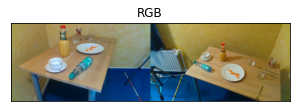

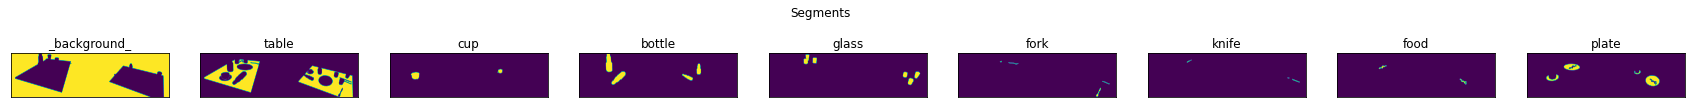

In [8]:
for i,j in dsTrain:
    showDatapoint(i[0],j[0])
    break
    

In [9]:
# y_train[:,:,:,0]= 0
# y_test[:,:,:,0]= 0

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

Using TensorFlow backend.


In [11]:
def ourBlock (x, basename, channels=9):
    x = layers.Conv2D (channels, 1, padding='same', name = basename+"_bottleneck_conv")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_bottleneck_BN')(x)
    x = layers.ReLU(6., name=basename+'_bottleneck_relu')(x)

    x = layers.Conv2D (4*channels, 1, padding='same', name = basename+"_conv")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_BN')(x)
    x = layers.ReLU(6., name=basename+'_relu')(x)

    x = layers.DepthwiseConv2D(kernel_size=3, activation=None, use_bias=False, padding='same', name=basename+'-DW')(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_DW_BN')(x)
    x = layers.ReLU(6., name=basename+'_DW_relu')(x)

    x = layers.Conv2D (channels, 1, padding='same', name = basename+"_project")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_project_BN')(x)

    return x

In [12]:
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# from keras.optimizers import Adam, RMSprop, SGD
# from tensorflow import keras
# from tensorflow.keras import layers

# model = MobileNetV2(weights="imagenet", include_top = False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# x =  model.get_layer("block_16_project_BN").output
# x = layers.ReLU(max_value=None, negative_slope=0, threshold=0 )(x)
# x = layers.ZeroPadding2D(padding=((1,1), (1,1)))(x)
# x = layers.DepthwiseConv2D(kernel_size=3, strides=(2, 2), depth_multiplier=1, activation=None, use_bias=False, padding='same')(x)
# x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999)(x)
# x = layers.ReLU(max_value=6, negative_slope=0, threshold=0 )(x)
# x = layers.ZeroPadding2D(padding=((1,1), (3,2)))(x)
# # x = layers.DepthwiseConv2D(kernel_size=3, strides=(1, 2), depth_multiplier=1, activation=None, use_bias=False, padding='same')(x)


# # x = ourBlock (x, "block_17")
   
# # x = layers.Conv2D (10, 1, padding='same', activation='relu', name = "block_1asdf8_conv_output")(x)
# # x = layers.Conv2D (10, 1, padding='same', activation='relu', name = "block_18_cosdfnv_output")(x)
# x = layers.Conv2D (10, 1, padding='same', activation='softmax', name = "bflock_18_conv_output")(x)

# model = keras.Model(inputs=model.input, outputs=predictions)
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.CategoricalAccuracy()])

# model.summary()

In [13]:
# history = model.fit(dsTrain, epochs=60)

In [14]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow import keras
from tensorflow.keras import layers

model = MobileNetV2(weights="imagenet", include_top = False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x =  model.get_layer("block_16_project_BN").output

# x = layers.ReLU(max_value=None, negative_slope=0, threshold=0 )(x)
# x = layers.ZeroPadding2D(padding=((1,1), (1,1)))(x)
x = layers.DepthwiseConv2D(kernel_size=3, strides=(2, 2), depth_multiplier=1, activation=None, use_bias=False, padding='same')(x)
x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999)(x)
x = layers.ReLU(max_value=6, negative_slope=0, threshold=0 )(x)
# x = layers.ZeroPadding2D(padding=((1,1), (3,2)))(x)
x = layers.Conv2D (9, 1, padding='same', activation='relu', name = "block_17_conv_output")(x)
x = layers.DepthwiseConv2D(kernel_size=3, strides=(2, 2), depth_multiplier=1, activation=None, use_bias=False, padding='valid',name='block_18_depthwise')(x)

x = layers.Conv2D (9, 1, padding='same', activation='relu', name = "block_18_conv_output")(x)
# x = layers.Conv2D (9, 1, padding='same', activation='relu', name = "block_17_middle_1conv_output")(x)
# x = layers.Conv2D (9, 1, padding='same', activation='relu', name = "block_17_middle_2conv_output")(x)
# x = layers.Conv2D (9, 1, padding='same', activation='softmax', name = "block_17_middle_3conv_output")(x)

# x = ourBlock (x, "block_17")
x = layers.UpSampling2D(interpolation='bilinear', name='block_19_upto16')(x)
x = layers.ZeroPadding2D(padding=((1,0), (1,1)))(x)
x = layers.UpSampling2D(interpolation='bilinear', name='block_20_upto14')(x)
x = layers.ZeroPadding2D(padding=((1,0), (0,0)))(x)

x = layers.Concatenate(name="block_20_concat")([x,model.get_layer("block_14_add").output])
x = ourBlock (x, 'block_20')

x = layers.ReLU(max_value=None, negative_slope=0, threshold=0 )(x)
x = layers.DepthwiseConv2D(kernel_size=3, strides=(2, 2), depth_multiplier=1, activation=None, use_bias=False, padding='valid')(x)
x = layers.UpSampling2D(size=(2,2),interpolation='bilinear', name='block_21_upto7')(x)
x = layers.UpSampling2D(interpolation='bilinear', name='block_21_upto7_II')(x)
x = layers.ZeroPadding2D(padding=((1,0), (1,1)))(x)
x = layers.ZeroPadding2D(padding=((0,0), (1,1)))(x)
x = layers.Concatenate(name="block_21_concat")([x,model.get_layer("block_7_add").output])
x = ourBlock (x, 'block_21')

x = layers.UpSampling2D(interpolation='bilinear', name='block_22_upto4')(x)
x = layers.Concatenate(name="block_22_concat")([x,model.get_layer("block_4_add").output])
x = ourBlock (x, 'block_22')

x = layers.UpSampling2D(interpolation='bilinear', name='block_23_upto2')(x)
x = layers.Concatenate(name="block_23_concat")([x,model.get_layer("block_2_add").output])
# # x = ourBlock (x, 'block_22')

x = layers.UpSampling2D(interpolation='bilinear', name='block_24_upto1')(x)
x = layers.Concatenate(name="block_24_concat")([x,model.get_layer("expanded_conv_project_BN").output])

x = layers.UpSampling2D(interpolation='bilinear', name='block_25_upto1')(x)
# # x = ourBlock (x, 'block_23', channels=4)

x = layers.Conv2D (9, 1, padding='same', activation='softmax', name = "block_25_conv_output")(x)



model = keras.Model(inputs=model.input, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Precision()])
# orig_stdout = sys.stdout
# f = open('/home/kate/model1_out.txt', 'w')
# sys.stdout = f
# print(model.summary())
# sys.stdout = orig_stdout
# f.close()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 720, 2560, 3 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 360, 1280, 32 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 360, 1280, 32 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 360, 1280, 32 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# with tf.device('cpu:0'):
history = model.fit(dsTrain, epochs=100)

Epoch 1/100
142/201 [====================>.........] - ETA: 27s - loss: 2.5493 - precision: 0.6081

In [ ]:
metrics = model.evaluate(dsTest, verbose=0)
print("Evaluated Metrics for the Test-Set:")
for name, value in zip(model.metrics_names, metrics):
    print(f"{name}: {value}")

In [ ]:
printX = dsTest.take(1)
predictedY = model.predict(printX)
m = np.argmax(predictedY, axis=-1)
predictedY = tf.one_hot(m, 10)
i=0
for x,y in printX:
    print("True Values")
    showDatapoint(x[i],y[i])
    print("Network results:")
    showDatapoint(x[i],predictedY[i])
